In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import functools

from networks import UnetGenerator
from datasets import loadHeat

In [2]:
# Define training parameters
batch_size=64
learning_rate = 1e-3
num_epochs = 200

In [7]:
# Input image handling
data_size = 16
dataset = loadHeat(data_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
# Initialize U-Net (or ResNet) convolutional architecture
# net = UnetGenerator(1, 1, 3, 64, norm_layer=functools.partial(nn.BatchNorm2d, affine=True), use_dropout=False, gpu_ids=[]).cuda()

class Codec(nn.Module):
    # Autoencoder for MNIST images
    def __init__(self):
        super(Codec, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv3 = nn.Conv2d(32, 4, kernel_size=3, padding=1)
        
        self.encoded = None # 4x4x4
        
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(16, 16, kernel_size=4)
        
        self.decode_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        # encoder
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        self.encoded = F.max_pool2d(self.pad(F.relu(self.conv3(x))), 2)

        # encoded representation is 8x4x4 = 128-dimensional encoding space

        # decoder
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        decoded = F.sigmoid(self.decode_conv(x))
        return decoded

net = Codec().cuda()
print(net)

Codec (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pad): ZeroPad2d (0, 1, 0, 1)
  (conv3): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
  (decode_conv): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [20]:
a = Variable(torch.rand(1,1,data_size,data_size))
net(a).data.shape

torch.Size([1, 1, 16, 16])

In [25]:
# Define physics loss
kernel = Variable(torch.Tensor(np.array([[[[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]]]]))).cuda()

def physical_loss(img):
    return F.conv2d(img, kernel).norm()

criterion = physical_loss
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [26]:
# Create output masks
center_mask = torch.zeros(dataset[0].shape).unsqueeze(0)
center_mask[:,:,:,0] = 1
center_mask[:,:,0,:] = 1
center_mask[:,:,:,-1] = 1
center_mask[:,:,-1,:] = 1

boundary_mask = torch.ones(dataset[0].shape).unsqueeze(0)
boundary_mask[:,:,:,0] = 0
boundary_mask[:,:,0,:] = 0
boundary_mask[:,:,:,-1] = 0
boundary_mask[:,:,-1,:] = 0

center_mask = Variable(center_mask).cuda()
boundary_mask = Variable(boundary_mask).cuda()

In [29]:
%autosave 100

Autosaving every 100 seconds


In [30]:
# Outer training loop
## Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        img = Variable(data).cuda()
        output = net(img)
        output = output*boundary_mask + img*center_mask
        loss = criterion(output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
#     if epoch % 10 == 0:
#         train_pic = to_img(img.cpu().data)
#         gen_pic = to_img(output.cpu().data)
#         save_image(train_pic, './decoded_mnist/image_{}_train.png'.format(epoch))
#         save_image(gen_pic, './decoded_mnist/image_{}_gen.png'.format(epoch))

epoch [1/200], loss:752.3678
epoch [2/200], loss:829.3467
epoch [3/200], loss:771.6237
epoch [4/200], loss:809.2115
epoch [5/200], loss:782.2800
epoch [6/200], loss:796.9957
epoch [7/200], loss:831.0916
epoch [8/200], loss:801.9062
epoch [9/200], loss:806.8330
epoch [10/200], loss:771.3583
epoch [11/200], loss:786.6263
epoch [12/200], loss:774.1788
epoch [13/200], loss:736.3974
epoch [14/200], loss:778.3044
epoch [15/200], loss:768.4051
epoch [16/200], loss:835.1226
epoch [17/200], loss:806.0500
epoch [18/200], loss:734.4946
epoch [19/200], loss:740.5313
epoch [20/200], loss:816.2125
epoch [21/200], loss:800.6907
epoch [22/200], loss:754.6627
epoch [23/200], loss:793.7491
epoch [24/200], loss:771.8560
epoch [25/200], loss:810.6707
epoch [26/200], loss:772.9658
epoch [27/200], loss:768.5406
epoch [28/200], loss:789.8983
epoch [29/200], loss:749.4062
epoch [30/200], loss:798.4147
epoch [31/200], loss:814.1380
epoch [32/200], loss:771.4526
epoch [33/200], loss:750.6043
epoch [34/200], los

In [ ]:
## Save model

In [32]:
# Output image handling
# heat = Variable(torch.Tensor(np.loadtxt('datasets/small_data/BC/0-10-20-90.csv', delimiter=','))).cuda()
heat = Variable(torch.Tensor(np.loadtxt('datasets/%d/BC/0-10-20-90.csv' % data_size, delimiter=','))).cuda()


In [33]:
output = net(heat.unsqueeze(0).unsqueeze(0))

In [34]:
output

Variable containing:
(0 ,0 ,.,.) = 

Columns 0 to 8 
   0.5972  0.9557  0.0603  0.1081  0.1837  0.1049  0.0473  0.0198  0.0216
  0.7915  1.0000  0.6571  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
  0.1132  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0427  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0062  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0169  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0011  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0004  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0004  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0007  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0009  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0001  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0086  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.00

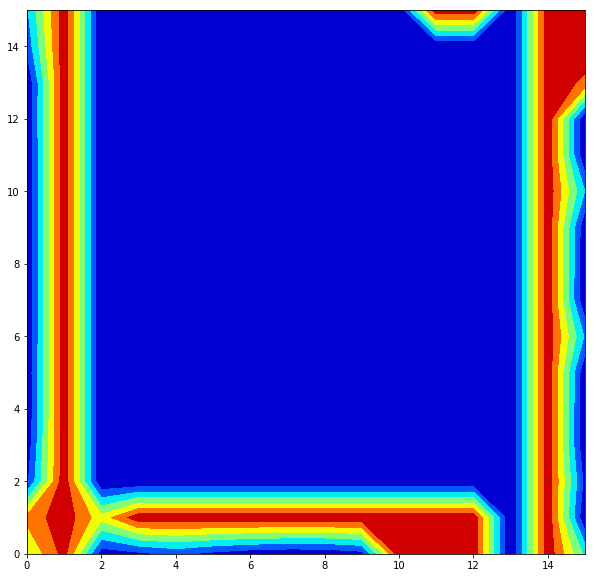

In [35]:
plt.figure(figsize=(10,10))
XX, YY = np.meshgrid(np.arange(0, dataset[0].shape[-1]), np.arange(0, dataset[0].shape[-1]))
plt.contourf(XX, YY, output.cpu().data.numpy()[0,0,:,:], colorinterpolation=50, cmap=plt.cm.jet)
# plt.imshow(output.cpu().data.numpy()[0,0,:,:])
plt.show()

---

---

---

---

---

---
# Miscellaneous Tests

In [2]:
kernel_ = np.array([[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]])
kernel = Variable(torch.Tensor(kernel_))
img = Variable(torch.rand(10,10))

def physical_loss(img):
#     return F.conv2d((img.unsqueeze(0)).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0)).norm()
    return F.conv2d((img.unsqueeze(0)).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

In [4]:
physical_loss(img)

Variable containing:
(0 ,0 ,.,.) = 
  0.0292  0.3121 -0.2342 -0.1250 -0.2445 -0.3733 -0.2806 -0.1527
 -0.1400  0.0060  0.4090 -0.1374  0.3424  0.0427  0.4813 -0.0692
 -0.4020  0.5477 -0.7780  0.2630  0.0718  0.2802  0.2284 -0.6202
  0.1652 -0.6265  0.2452  0.3149 -0.2875 -0.3081 -0.1356  0.6590
 -0.3522  0.6148 -0.2975  0.1686 -0.2690 -0.1233  0.1784 -0.2472
 -0.0768 -0.2584  0.2547  0.2669 -0.1479  0.3965  0.1607  0.1083
 -0.4120  0.3863  0.2018 -0.5286  0.2726 -0.0041 -0.4462  0.2418
  0.5019  0.2671 -0.2837 -0.2454 -0.3699 -0.2484  0.1922  0.3512
[torch.FloatTensor of size 1x1x8x8]

In [5]:
# Heat is true ground truth solution
heat_ = np.loadtxt('datasets/32_small/field/0-10-20-90.csv', delimiter=',')
heat = Variable(torch.Tensor(heat_))
heat

Variable containing:
 20.0000  10.0000  10.0000  ...   10.0000  10.0000  90.0000
 20.0000  15.0134  13.0503  ...   34.1378  49.9750  90.0000
 20.0000  17.0032  15.0536  ...   49.8999  65.7621  90.0000
           ...               ⋱              ...            
 20.0000  13.9912  10.0765  ...   44.9228  62.7501  90.0000
 20.0000  10.0191   6.0853  ...   27.1727  44.9807  90.0000
 20.0000   0.0000   0.0000  ...    0.0000   0.0000  90.0000
[torch.FloatTensor of size 64x64]

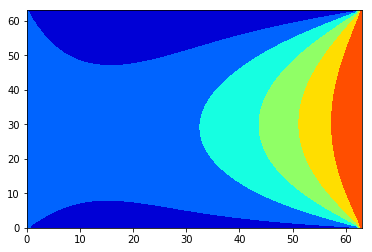

In [6]:
XX, YY = np.meshgrid(np.arange(0, 64), np.arange(0, 64))
plt.contourf(XX, YY, heat.data.numpy(), colorinterpolation=50, cmap=plt.cm.jet, vmin=0, vmax=100)
plt.show()

In [7]:
physical_loss(heat)

Variable containing:
(0 ,0 ,.,.) = 
1.00000e-03 *
  0.0072  0.0136  0.0191  ...   0.0143  0.0095  0.0038
  0.0143  0.0234  0.0329  ...   0.0257  0.0124  0.0038
  0.0191  0.0334  0.0458  ...   0.0334  0.0191  0.0076
           ...             ⋱             ...          
  0.0148  0.0229  0.0327  ...   0.0210  0.0095  0.0057
  0.0088  0.0143  0.0199  ...   0.0114  0.0081 -0.0010
  0.0038  0.0052  0.0072  ...   0.0043  0.0010 -0.0019
[torch.FloatTensor of size 1x1x62x62]

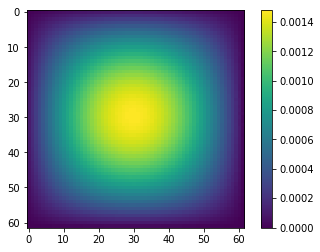

In [8]:
# Ground truth satisfies small value when kernel is applied
plt.imshow(physical_loss(heat).data.numpy()[0,0,:,:])
plt.colorbar()
plt.show()